# 1. 剧情回顾

在上一个[notebook](https://github.com/rikichou/yolo/blob/master/YOLO_face_detection_and_recognition_1--first_sight_of_darknet.ipynb)中，我简要介绍了darknet，它是一个使用C语言实现的深度学习框架，里面提供了YOLO模型的配置文件以及预训练权重，我们可以轻易地通过几行命令就能够实现目标检测。但是假如我们想用自己的数据搭建一个YOLO目标检测模型的话，改怎么做呢？也就是说，我们要利用darknet在我们自己提供的数据上，对YOLO模型进行训练，改怎么做？其实，[darknet](https://pjreddie.com/darknet/yolov2/)官网已经提供了相应的例子来说明如何训练

× 注意：我所说的YOLO其实是YOLOV2

# 2.VOC数据集

严格地说应该叫[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)数据集，该数据集是一个用于构建图片分类，目标检测，图片分割的数据集。2005--2012年，每年都会举办Pascal VOC挑战赛，在2012年，由于VOC项目的重要成员Mark Everingham去世，所以该比赛就停止了。

该数据集包含了用于目标检测的图片数据以及相应的annotations信息，其中该数据集包含20个类别检测对象。我们将利用2007年和2012年的数据集对YOLO模型进行重新训练。

darknet官网很人性化地提供了VOC数据集的[下载链接](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)，首先进入darknet目录，然后通过以下命令可以直接下载数据集并解压到当前目录：

    wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
    wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
    
    tar xf VOCtrainval_11-May-2012.tar
    tar xf VOCtrainval_06-Nov-2007.tar
    tar xf VOCtest_06-Nov-2007.tar

说明：首先建议用迅雷下载，用wget或者自带浏览器下载比较慢。另外，如果你是在云服务器上进行训练的话，那就只能用wget下载了，此时不建议在darknet网站下载此数据，建议直接在Pascal VOC的比赛官网下载2007和2012的对应的那三个文件，速度很快。

## 2.1 了解数据

数据集解压之后，数据的结构大概如下：

--|VOCdevkit  
--|-----VOC2007  
--|----------Annotations  
--|----------ImageSets  
--|---------------Main  
--|----------JPEGImages  
--|----------SegmentationClass  
--|----------SegmentationObject  
--|-----VOC2012  
--|----- .  
--|----- .  
--|----- .  

VOC2007和VOC2012就是我们解压的两个之后的数据集文件夹，他们两个的目录结构完全一致。接下来我们来说说我们需要了解的文件。

Annotations文件夹包含了M个xml文件，M表示图片的数量。这些xml文件里面包含了图片的基本信息，比如图片的大小，以及图片中包含的目标，目标的bounding box，目标的类别等等信息，这些信息在我们训练的时候需要用到。

ImageSets文件夹里面我们只关心Main文件夹，Main文件夹里面都是txt文件，每个txt文件都包含了对应的数据集中每个图片的ID。比如train.txt文件中包含了训练集的图片的ID。

JPEGImages文件夹里面包含了我们真正的图片数据

剩下的两个文件夹是关于图片分割的内容，我们也不关心

# 3 训练

了解了数据之后我们就可以开始按照官网上的教程进行训练流程了。开始训练之前，还需要做一件事情就是训练数据的标签提取

## 3.1 label提取

因为我们是使用darknet来训练YOLO，所以我们需要将数据集的label转换为darknet希望的形式。darknet希望为每一张图片都建立一个对应的txt文件来表示一张图片的信息，该信息的格式如何：

    <object-class> <x> <y> <width> <height>
    
object-class为对象的类别，voc数据集可能有多个类别。  
x为对象（bounding box）的中心点横坐标  
y为对象（bounding box）的中心店的纵坐标  
width为对象（bounding box）的宽度
hight为对象（bounding box）的高度  

其中在TXT文件中，每一行代表一个bounding box的信息，如果一张图片有多个对象，那么对应地就会有多行类似上面的数据

注意：以上的计算都是以图片左上角为坐标原点(0, 0)，图片右下角为坐标(1, 1)，所以以上的取值都在[0,  1]之间

那么清楚了格式之后如何来提取呢？其实，darknet早就帮我我们写好了提取label的脚本了，我已我们只需要下载脚本，运行脚本就好了。

wget https://pjreddie.com/media/files/voc_label.py

python voc_label.py

运行结束之后，在darknet目录下生成了多个TXT文件(2007_train.txt 2007_test.txt 2007_val.txt 2012_train.txt 2012_val.txt)，这些TXT文件包含了对应数据集的中每张图片的绝对路径。

另外，我们会发现在我们每个数据集的目录下（比如darknet/VOCdevkit/VOC2007/labels）多了一个labels文件夹，改文件夹里面包含了许多TXT文件，这些TXT文件就是我们需要的每张图片的label信息。

紧接着，因为我们要将2007_train.txt 2007_val.txt 2012_train.txt 2012_val.txt等文件中表示的图片作为训练集了训练YOLO模型，所以我们把这些TXT文件合并成一个大的TXT文件传输给darknet

cat 2007_train.txt 2007_val.txt 2012_*.txt > train.txt

## 3.2 建立配置文件

在使用darknet训练YOLO模型的时候，我们需要建立配置文件来告诉darknet数据集的信息。这些信息包括

1， 该数据集一共含有多少类对象  
2， 该数据集每一类对象的名字  
3， 包含训练集图片的绝对路径的TXT文件在哪儿  
4， 包含验证集图片的绝对路径的TXT文件在哪儿

darknet已经有了该配置文件cfg/voc.data，我们只需要做适当的修改就好了。

classes= 20  
train  = train.txt  
valid  = 2007_test.txt  
names = data/voc.names  
backup = backup  

因为我的TXT文件都生成在了darknet的目录里面，所以直接写相对路径就好了

## 3.3 下载预训练权重

YOLOV2的论文中，在对YOLO的目标检测模型进行训练之前，将YOLO作为分类模型在ImagNet数据集上进行了预训练，训练的具体参数在这里不提，感兴趣的可以去看看论文。

为什么要这样做呢？我们知道图片数据的基本结构都是很相似的，都是由一些边缘组成基本形状然后再组成抽象的物体，也就是说对于图片的很多特征，特别是底层的特征，我们是可以共享的。既然如此，我就可以先让YOLO在大数据集（imagenet）中学习到一些通用的“知识”（表现为卷积层权重），然后再将这些“知识”作为训练目标检测模型的初始权重，那么这样就可以以这些“知识”为基础进行学习，大大提升了学习的效率，这就是我们所说的迁移学习！

所以我们可以将YOLO模型作为分类模型在imagenet上的1000类的庞大数据集中进行与训练，然后再将这些权重作为初始权重来进行目标检测的学习。当然，我肯定不会去做这个预训练的步骤，感兴趣的朋友可以去论文中获取具体训练的细节。

darknet支持支持在训练的时候载入预训练权重，所以我们只需要下载该权重即可，darknet提供了该权重的下载

wget https://pjreddie.com/media/files/darknet19_448.conv.23

## 3.4 修改要训练的YOLOV2模型的配置文件

之前在3.2节中我们修改的是关于数据的配置文件，现在我们需要修改的是模型的配置文件，我们使用的模型是yolov2，所以对应地在cfg/yolov2-voc.cfg文件中就包含了该模型的配置信息以及训练该模型的参数信息，这里我们仅仅需要修改一个batch size参数就好了。

这里我们将cfg/yolov2-voc.cfg文件中前几行改为如下形式就好了

    [net]
    # Testing
    # batch=1
    # subdivisions=1
    # Training
    batch=64
    subdivisions=8

注意官网并没有提及3.4这一步，如果没有进行这一步，那么我们的样本训练的batch size将会是1，这个batch size是在预测的时候使用的，这样在训练了大约6000张图片后，你就会发现你的IOU和其他一些训练的调试信息将会变成NaN,就是这个参数造成的。

## 3.5 训练

现在一切准备就绪，可以开始训练了，其实训练就一句话

./darknet detector train cfg/voc.data cfg/yolov2-voc.cfg darknet19_448.conv.23

    train:代表我们现在进行的是训练
    cfg/voc.data：是本次训练的配置文件
    cfg/yolov2-voc.cfg：这是YOLOV2模型的配置文件
    darknet19_448.conv.23：这是YOLO模型的预训练权重

在这里我声明一下，我开始训练的时候使用的是我自己的主机上进行训练的，我的机器配置是GTX 960 GPU，2GB显存，不出意外地，训练过程中，直接报了类似“out of memory”之类的信息，即使把batch size调整到16，训练大概不到300个batch的时候也会报错，所以我直接放弃在本地训练该项目的想法。

这里我推荐一个[亚马逊EC2云服务器](https://amazonaws-china.com/cn/ec2/?hp=tile&so-exp=below)，可以在上面租用云服务器进行模型的训练，价格相对国内的阿里云或者腾讯云更便宜。只不过你需要准备一张普通信用卡，而且用完了服务器之后一定要关闭，具体的细节在这里就不介绍了，感兴趣的可以看此[教程](https://zhuanlan.zhihu.com/p/33173963?utm_source=wechat_session&utm_medium=social)。EC2的缺点就是使用和申请提升实例限制比较繁琐，如果嫌麻烦的同学可以试试阿里云或者腾讯云，比EC2方便！

这里我使用的是EC2中的p2.xlarge云服务器，GPU为Tesla K80，12GB显存，足够应付本次训练。

在训练的过程中，要注意观察输出的打印信息，如果发现很多参数都是nan的话那就可能是你的模型配置文件没有配置好，比如batch size不对，或者learning rate过高（这是在使用自己的数据集进行训练的情况下，一般voc数据集就使用默认的配置就好，但是也要执行3.4步的修改才行）

# 4 人脸检测模型的训练



好像到目前为止，我们的操作有点儿偏题了，不是说好了在人脸数据上进行训练么？其实刚才只是为了让我们更熟悉使用darknet进行训练的流程，现在我们就选择一个人脸数据集进行训练。我们选择的是著名的人脸检测数据集：[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

## 4.1 更改模型配置文件



虽然我们依旧使用YOLOV2的模型进行训练，但是现在任务以及数据集确改变了，此时我们不再检测VOC数据集的20个类别的目标，我们只检测1个类别：是否是人脸，所以现在需要对yolov2-voc.cfg文件进行修改，这里我们拷贝yolov2-voc.cfg为yolov2-celeba.cfg，下面对yolov2-celeba.cfg进行修改

    1.batch=64 subdivisions=8

    2.classes=20改为classes=1

    3.将237行的filters=125改为filters=30，30是这样算出来的(类别数量 + 5) * anchor数量 = 30，其中5代表的是xywh坐标以及class类标签

另外，在配置[region]里面的anchors参数表示anchors大小，这个和具体的数据集相关，因为我们训练的数据集是CelebA,所以不能够使用VOC的anchors，我们需要在CelebA数据集上使用k-means聚类算法来得出anchors的大小。具体的做法在4.3.5中。

## 4.2 创建类别名称文件

之前我们的voc.names里面包含了每一类别对象的名称，虽然现在只有一个类别，但是也应该指定名称，我们现在再data目录下创建一个celeba.names，里面只有一行内容，就是face。

## 4.3 创建数据集相关的文件

在3.1节中，我们利用voc_label.py这个脚本创建了关于数据集路径的TXT文件，而且还为每张图片创建了关于图片对象的bounding box信息的TXT文件。但是这里我们使用不同的数据集，这个脚本就用不上了，我们需要自己写程序来完成类似的功能。

### 4.3.1 了解数据集

在做上述的这一切之前，让我们来了解了解我们将要使用的数据集。

[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)是一个大规模人脸属性数据集，其拥有超过20W张名人的图像（貌似没看到亚洲人？），每张图片拥有40个属性标注，比如是否戴眼镜，是否微笑，是否戴帽子等等，当然还有我们需要的bounding box的标注。该数据集中的图像中的人物摆出了不同角度的姿势，并且图像拥有 复杂的背景。更准确地，该数据集拥有10177个名人的202599张脸部图像，每张图像拥有5个脸部位置标记以及40个二值属性。

官网的下载链接已经无法使用了，但是官网给出了另外两个下载链接，一个是[百度云盘](https://pan.baidu.com/s/1eSNpdRG#list/path=%2F)，一个是[谷歌云盘](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8)，我是从百度云盘下载的，不知道什么原因，谷歌云盘的下载下来的文件丢失了许多！

在文件下载下来了以后，我们会发现文件呈现如下的结构：

|----CelebA  
|　　｜----Img  
|　　｜　　｜----img_celeba.7z  
|　　｜----Eval  
|　　｜　　｜----list_eval_partition.txt  
|　　｜----Anno  
|　　｜　　｜----list_bbox_celeba.txt  


其中Img目录为存放图片的目录，里面包含了三个文件。第一个文件夹是img_celeba.7z，里面是原始的训练集图片，这就是我们做人脸检测的数据集。第二个文件是img_align_celeba.zip，从名字可以看出，这里面包含了在原始图片上进行裁剪的图片，只有一个大头，这种数据适合用于做人脸识别。第三个文件夹是img_align_celeba，这个文件夹里面的图片其实和第二个文件里的一样，只不过这个文件夹里的图片格式是png，更清晰！所以这里我们只关心img_celeba.7z文件夹，请自行将其解压缩。

在Eval中，list_eval_partition.txt文件已经为我们划分好了0--训练集，1--验证集，2--测试集

在Anno中，list_bbox_celeba.txt文件包含了每一张图片的bounding box，该bounding box的表示方法是box左上角的坐标x,y以及该box的宽度高度w,h。

由于我们并不需要所有的数据，所以我现在要将刚才解压出来的部分数据拷贝出来用于darknet的训练。（我假装你就是在darknet目录下加压出CelebA的）

假设当前目录是darknet目录，我们创建一个celeba目录，并且仿造VOC目录结构，在celeba目录下创建一个labels目录和JPEGImages目录，现在要做的就是将所有位于./darknet/CelebA/Img/img_celeba中的图片拷贝（我使用的软链接，节约空间）到./darknet/celeba/JPEGImages目录下。那么此时我们的darknet的目录结构大概如下：

|----darknet  
|　　｜----CelebA  
|　　｜　　｜----Img  
|　　｜　　｜----Eval  
|　　｜　　｜----Anno  
|　　｜----celeba  
|　　｜　　｜----JPEGImages   
|　　｜　　｜----labels  
|----yolo  
|　　｜----YOLO_face_detection_and_recognition_2--train_yolo_on_CelebA_datasheet.ipynb  

我们待会儿在4.4节会解释为什么需要将我们的数据存放在celeba目录中。

(有必要说明一下，本notebook文件存放的目录就是上图中的yolo目录下)

### 如何将数据集下载到你的云服务器

(本地训练的朋友就不用看了)我使用的是亚马逊的云服务器进行训练的，所以我需要想办法把Google云盘里的数据传到云服务器里面，如果直接在本地上传的话，30KB/s的速度会让你发疯的。所以我选择直接在云服务器里面使用wget来下载Google云盘里面的数据集，具体的下载方法如下：

1. 首先需要一个下载工具，这个工具叫做gdown，在这个[Git仓库](https://github.com/circulosmeos/gdown.pl)里面克隆
2. 接下来就是获取下载的链接地址，我们的数据集在Google云盘上，进入云盘，右键你要下载的文件(只能单个单个文件下载，不支持文件夹)，比如img_celeba.7z.001,选择“共享”，记住不是“获取共享链接”哟！然后得到一个链接地址，比如：https://drive.google.com/file/d/0B7EVK8r0v71peXc4WldxZGFUbk0/view?usp=sharing  
然后我们把"view"以及后面的链接字段去掉，变成如下：  
https://drive.google.com/file/d/0B7EVK8r0v71peXc4WldxZGFUbk0  
这就是我们的下载的链接地址了。
3. 接下来就是运行命令，下载咯。  
./gdown.pl https://drive.google.com/file/d/0B7EVK8r0v71peXc4WldxZGFUbk0  img_celeba.7z.001  
亚马逊的P2.xlarge云服务器下载速度太爽啦！60M每秒！其实上传速度也和下载速度差不多！所以我可以很轻松的把我的200M的权重文件上传到git（当然这里使用的是git lfs，不然普通git是无法上传大于100M的文件的，想要了解的朋友可以在这个[链接](https://www.jianshu.com/p/493b81544f80)了解到）

In [1]:
import os
import shutil

proj_dir = os.path.dirname(os.getcwd())
darknet_dir =  proj_dir + "/darknet"
bbox_path = darknet_dir + '/celeba/list_bbox_celeba.txt'
eval_path = darknet_dir + '/celeba/list_eval_partition.txt'

if not os.path.isdir(darknet_dir+"/celeba"):
    
    print ("Now to create data dir to compatible with darknet")
    
    os.makedirs(darknet_dir+"/celeba/JPEGImages")
    os.makedirs(darknet_dir+"/celeba/labels")
    
    ## copy the txt file
    shutil.copyfile(darknet_dir+"/CelebA/Anno/list_bbox_celeba.txt",bbox_path)
    shutil.copyfile(darknet_dir+"/CelebA/Eval/list_eval_partition.txt",eval_path)
    
    ## create link from source image data
    filenames = os.listdir(darknet_dir+"/CelebA/Img/img_celeba.7z/img_celeba")
    
    for name in filenames:
        os.symlink(darknet_dir+"/CelebA/Img/img_celeba.7z/img_celeba/"+name, darknet_dir+"/celeba/JPEGImages/"+name)

Now to create data dir to compatible with darknet


### 4.3.2 可视化

下面来简单地可视化一下，了解了解我们的数据是什么样子的。

108 172 263 364


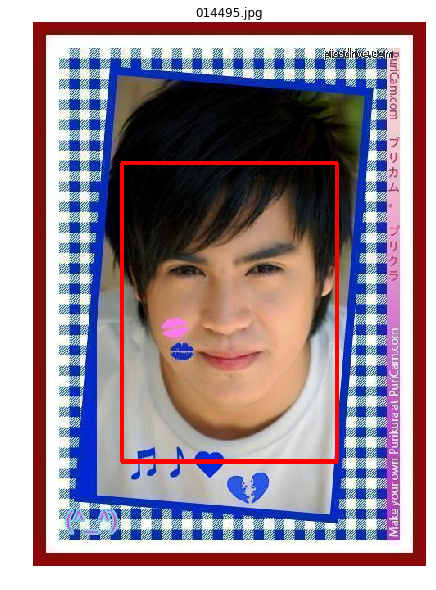

In [21]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline


## read bounding box
img_bbox = {}
with open(darknet_dir+"/CelebA/Anno/list_bbox_celeba.txt") as f:
    lines = f.readlines()
    lines=lines[2:]
    
    line = lines[np.random.randint(len(lines))].strip().split()
    
    img_bbox["name"] = line[0]
    img_bbox["x"] = int(line[1])
    img_bbox["y"] = int(line[2])
    img_bbox["w"] = int(line[3])
    img_bbox["h"] = int(line[4])
    
## read image
img_path = darknet_dir+"/CelebA/Img/img_celeba.7z/img_celeba/" + img_bbox["name"]
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
(img_h, img_2) = img.shape[0:2]

print (img_bbox["x"], img_bbox["y"], img_bbox["w"], img_bbox["h"])
## display
cv2.rectangle(img,(img_bbox["x"],img_bbox["y"]),(img_bbox["x"]+img_bbox["w"],img_bbox["y"]+img_bbox["h"]),(255,0,0),3)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.title(img_bbox["name"])
plt.show()

### 4.3.3 训练集测试集验证集划分

其实就是生成train.txt  val.txt  test.txt,根据前面的描述，list_eval_partition.txt这个文件中已经分配好了这些，0代表训练集，1代表验证集，2代表测试集。

In [4]:
train_txt = darknet_dir + '/celeba/train.txt'
val_txt = darknet_dir + '/celeba/val.txt'
test_txt = darknet_dir + '/celeba/test.txt'

train_p = open(train_txt, "w")
val_p = open(val_txt, "w")
test_p = open(test_txt, "w")

with open(eval_path) as p:
    lines = p.readlines()
    t = 0
    v = 0
    e = 0
    for line in lines:
        items = line.strip().split()
        img_path = darknet_dir+"/celeba/JPEGImages/" + items[0] + '\n'
        img_type = int(items[1])
        
        if img_type == 0:
            train_p.write(img_path)
            t += 1
        elif img_type == 1:
            val_p.write(img_path)
            v += 1
        else:
            test_p.write(img_path)
            e += 1
    print ("train {}, validation {}, test {}".format(t, v, e))

train_p.close()
val_p.close()
test_p.close()

train 162770, validation 19867, test 19962


### 4.3.4 生成每张图片对应的label

darknet需要为每一张图片都建立一个txt文件，该文件描述了该张图片的bounding box的情况以及类别（我们只有一类，所以为0就好），这里我们来创建这些txt文件，并将其放入labels文件夹。

In [5]:
labels_dir = darknet_dir+"/celeba/labels"

def get_w_h(img_name):
    img_path = darknet_dir+"/celeba/JPEGImages/" + img_name
    img = cv2.imread(img_path)
    shape = img.shape
    return shape[1], shape[0]

if not os.listdir(labels_dir):
    with open(bbox_path) as f:
        lines = f.readlines()
        lines = lines[2:]

        for line in lines:
            items = line.strip().split()

            img_name = items[0]
            txt_name = img_name[:-3]+'txt'

            with open(labels_dir+'/'+txt_name, "w") as tf:
                x = int(items[1])
                y = int(items[2])
                w = int(items[3])
                h = int(items[4])

                (width, hight) = get_w_h(img_name)

                txt = "0 " + str((x + w/2.0)/width) + " " + str((y + h/2.0)/hight) + " " + str(w/width) + " " + str(h/hight) + '\n'

                tf.write(txt)

### 4.3.5 对CelebA数据集进行k-means聚类生成anchors

cfg/yolov2-voc.cfg里面配置的anchors参数是根据VOC数据集生成的，但是我们现在使用的CelebA数据集，其anchors形状和VOC数据集有很大的差别，所以我们应该按照论文上说的，利用k-means算法来对CelebA数据集的bounding box进行聚类。

    1，我们只对宽度和高度进行聚类
    2，聚类的宽度和高度是labels/xxxx.txt里面的w和h
    3，聚类的距离衡量为1 - IOU(box1, box2)
    
如果你了解k-means聚类算法的话，那有了上面的信息之后，就很容易实现了。这里我们的实现代码在get_anchors.py中，代码的实现参考了[git](https://github.com/PaulChongPeng/darknet/blob/master/tools/k_means_yolo.py)

在运行下面的代码之前，你需要修改一下你的jupyter notebook配置文件，jupyter_notebook_config.py中的

    c.NotebookApp.iopub_data_rate_limit = 1000000000
    
然后重启jupyter notebook，否则该函数无法执行的，会提示类似"IOPub data rate exceeded."的信息

In [6]:
from get_anchors import compute_centroids

"""
    label_path: include images path
    n_anchors:anchors num
    loss_convergence:stop iteration when loss < loss_convergence
    grid_size:model ouput grid size
    iterations_num:maximun iteration num
    plus:whether using k-mean++
"""
compute_centroids(label_path=train_txt, n_anchors=5, loss_convergence=1e-6, grid_size=13, iterations_num=100, plus=0)

loss = 38696.434003
4.482002190075871 5.262101125262909
6.1621541810312905 9.492500827025765
2.6498116876073983 3.019946954335311
9.260833352656721 9.76277169233631
6.822815001540906 6.953107663190635
loss = 37219.522100
4.496351025935994 5.2909994428741625
5.8501898945099775 9.360511144470404
2.7561566436155744 3.12668620717353
9.053582564429625 9.6288991423679
6.741024069354092 6.841897799070234
loss = 36664.760834
4.514520430071153 5.284526158049752
5.593012894642388 9.22382058317764
2.7987682738607442 3.173391171408712
8.902712829413625 9.542614709531113
6.712510516367017 6.785803679289381
loss = 36352.787921
4.524395677940234 5.253930546144026
5.374382793333442 9.079495028989538
2.818610672935034 3.190933468577507
8.797820552302696 9.496585647535252
6.7003000426225 6.757274700879004
loss = 36119.053658
4.529200445643612 5.2092611517845135
5.210721531984061 8.945529741584435
2.821127472719184 3.20194173131965
8.728105184001281 9.476686419213157
6.689548956739279 6.740018916953354
l

loss = 35339.677142
4.725931828744662 4.7909277524068905
4.119031275578154 7.789234598258672
2.7885743907205853 3.296797126677181
8.378783809513987 9.457474359537708
6.526197914119907 6.788686719103974
loss = 35338.797060
4.7258027161218115 4.7905378951977955
4.117904456506904 7.7876637697831335
2.7885219557220955 3.2965635968026734
8.377004872060454 9.45642006317763
6.525429470753601 6.787329599998914
loss = 35337.666509
4.725588292505969 4.790162710143217
4.1169488361599385 7.786262174297505
2.78841696131808 3.2963410465235956
8.375752014693521 9.455930500293093
6.524858691969857 6.786472682297631
loss = 35337.056282
4.725582086168351 4.7898539904961535
4.116594350134362 7.785326567219524
2.7883926656784688 3.2962294529091216
8.375289308908483 9.455472157163607
6.52449890206214 6.786144428708133
loss = 35336.620364
4.725483588586148 4.789585219163108
4.116250295823179 7.783830413258716
2.7883804470120834 3.2961016301228305
8.374568256791857 9.455411452598078
6.524329896887669 6.78581

现在咱们就把cfg/yolov2-celeba.cfg的anchors参数改为上面输出的5对值。


    anchors = 2.78625 3.29271 8.36142 9.45355 4.73254 4.77603 4.09317 7.72644 6.51961 6.78404

## 4.4 创建数据集配置文件

接下来我们要模型voc数据集的配置文件cfg/voc.data来创建一个我们自己的数据集配置文件cfg/celeba.data。

    classes= 1
    train  = celeba/train.txt
    valid  = celeba/val.txt
    names = data/celeba.names
    backup = backup
    
我们在4.3.1节中留了一个问题，就是为什么需要那样来建立存放数据集的文件夹？这里来解释一下。

我们知道，在训练的时候，我会把cfg/celeba.data文件以参数的形式传递给darknet，这样darknet才知道训练集和验证集的文件在哪里。但是又一个问题，我们并没有告诉darknet labels文件夹在哪个路径，darknet是怎么找到一张图片相应labels文件呢？

其实，我也是看了源码才知道的，在darknet源码的data.c的220行，有这样一个函数调用

    find_replace(labelpath, "JPEGImages", "labels", labelpath);

然后接着又有一个这样的函数调用

    find_replace(labelpath, ".jpg", ".txt", labelpath);

其实这两个函数就是在利用图片的路径来得到图片对应的labels文件的路径，怎么做的呢？加入图片路径labelpath = "darknet/celeba/JPEGImages/000001.jpg",那么第一个函数调用就是将labelpath路径里面的"JPEGImages"字符串替换为"labels"字符串，那么此时labelpath就变成了"darknet/celeba/labels/000001.jpg"。紧接着第二个函数调用将labelpath路径里面的".jpg"替换为".txt"字符串，此时labelpath就变成了"darknet/celeba/labels/000001.txt"，这不就是000001.jpg图片对应的label文件么。

所以darknet就是这样来得到label的txt文件的，所以我们需要做的就是在JPEGImages文件夹里面放图片，在labels文件夹里面放bounding box信息，而且JPEGImages和labels文件夹要处于同一目录下，这样darknet就可以找到所有它需要的东西了

## 4.5 开始训练

在训练之前，还有一件重要的事情要说明一下，我们之前介绍了在VOC数据集训练YOLO模型，训练过程中每隔100次迭代就会在backup目录下保存一次训练权重，但是你不要以为如果你迭代了4000次，就会有40个权重文件被保存了。在darknet的源码里面，examples/detectors.c的138行有如下的代码：

    if(i%10000==0 || (i < 1000 && i%100 == 0))
    
i代表的迭代次数，也就是在i < 1000的时候，每迭代100次，就保存一次权重。但是在i > 1000次之后，每迭代10000次，才会保存一次权重！！！这是非常非常非常令人困惑的设置，特别是当你从凌晨3点训练到中午11点的时候，你发现你已经迭代了5000次，然而只保存了100-900的权重！1000--5000之间的权重都没有！！而且在迭代了900次的时候，模型是没有收敛，所以那个权重没用！（这是教训啊！我也是训练后才知道的！），我建议每隔500次就保存一下权重，所以你需要自己去修改源码为：
    
    if(i%500==0 || (i < 1000 && i%100 == 0))

然后就在重新编译darknet就好了

    make clean
    make

废话不多说，开始训练，直接运行脚本

./darknet detector train cfg/celeba.data cfg/yolov2-celeba.cfg darknet19_448.conv.23

这里我推荐一个[教程](https://github.com/AlexeyAB/darknet/tree/47c7af1cea5bbdedf1184963355e6418cb8b1b4f#how-to-train-pascal-voc-data)，这个教程介绍了如何训练YOLO，以及什么时候结束训练，介绍得非常好。

## 4.6 训练结果

经过了一晚上的训练早上3点到中午11点，迭代了大概5000次左右，从输出来看，模型是收敛了，平均IOU在0.8左右，loss在0.5-0.6之间，要知道刚开始训练的时候loss是好几百！大概输出如下：


Region Avg IOU: 0.848645, Class: 1.000000, Obj: 0.752113, No Obj: 0.003160, Avg Recall: 1.000000,  count: 8  
Region Avg IOU: 0.892837, Class: 1.000000, Obj: 0.888653, No Obj: 0.004489, Avg Recall: 1.000000,  count: 8  
Region Avg IOU: 0.900721, Class: 1.000000, Obj: 0.901891, No Obj: 0.003784, Avg Recall: 1.000000,  count: 8  
Region Avg IOU: 0.883814, Class: 1.000000, Obj: 0.840705, No Obj: 0.003693, Avg Recall: 1.000000,  count: 8  
Region Avg IOU: 0.832749, Class: 1.000000, Obj: 0.846868, No Obj: 0.002831, Avg Recall: 0.875000,  count: 8  
Region Avg IOU: 0.858090, Class: 1.000000, Obj: 0.849236, No Obj: 0.003649, Avg Recall: 1.000000,  count: 8  
Region Avg IOU: 0.849732, Class: 1.000000, Obj: 0.816533, No Obj: 0.002835, Avg Recall: 1.000000,  count: 8  
Region Avg IOU: 0.873212, Class: 1.000000, Obj: 0.859132, No Obj: 0.003457, Avg Recall: 1.000000,  count: 8  
5038: 0.659165, 0.881527 avg, 0.001000 rate, 11.047232 seconds, 322432 images  

可以看到平均的recall基本上是1，也就是说训练集中出现的bounding box都被预测到了！  
还有一点，上面我们将了，我只保存了100-900次迭代的权重。但是幸好darknet虽然没有帮我保存900--5000之间的权重，但是其会将当前最新的权重保存在yolov2-celeba.backup这个文件里，所以我在4700--5000次迭代的时候手动把这个最新的权重copy出来了，所以接下来我测试的时候就会使用这些我拥有的权重

## 4.7 验证集结果

在对验证集进行预测之前，还需要改源代码！不知道什么原因，源代码(examples/detector.c 496行)在进行evaluation的时候，竟然手动指定了validation数据集的位置：

    list *plist = get_paths("data/coco_val_5k.list");

所以我们需要将路径改为我们放置val.txt的地方

    list *plist = get_paths("celeba/val.txt");
    
然后就在重新编译darknet就好了

    make clean
    make

然后我们运行下面的命令来对我们的val.txt数据集进行预测

./darknet detector recall cfg/celeba.data cfg/yolov2-celeba.cfg backup/yolov2-celeba_5000.weights

    19862 19829 19863       RPs/Img: 36.68  IOU: 87.13%     Recall:99.83%
    19863 19830 19864       RPs/Img: 36.67  IOU: 87.13%     Recall:99.83%
    19864 19831 19865       RPs/Img: 36.67  IOU: 87.13%     Recall:99.83%
    19865 19832 19866       RPs/Img: 36.67  IOU: 87.13%     Recall:99.83%
    19866 19833 19867       RPs/Img: 36.67  IOU: 87.13%     Recall:99.83%

该数据集一共有19000多张图片，最终我们的recall在99.8%左右，平均的IOU在87.13%左右，可以说效果非常地好！

 RPs/Img代表平均每张图片预测出了多少个框（这个和我们定的阈值有关，只要大于这个阈值，YOLO就算他是一个预测出来的框，所以阈值越大，淘汰的低置信度的框就越多， RPs/Img越小，精确度就越高，recall就越小。阈值越小，RPs/Img越大，精确度就越小，recall就越大）

## 4.8 测试集的预测

说明一下，这个数据集给我们提供了测试集的标签（因为比赛结束很久了，所以标签给出来就没什么奇怪的），接下来我们就来看看我们训练的模型在测试集上的预测效果吧！（我是在云服务器上进行预测，再把预测的图片拷贝出来的，所以这里显示一下！接下来的notebook会将YOLO模型移植为Python版本，进行人脸识别！！！）

./darknet detector test cfg/celeba.data cfg/yolov2-celeba.cfg backup/yolov2-celeba_5000.weights celeba/JPEGImages/182638.jpg

    mask_scale: Using default '1.000000'
    Loading weights from backup/yolov2-celeba_5000.weights...Done!
    celeba/JPEGImages/182638.jpg: Predicted in 0.049183 seconds.
    face: 90%
    
从打印信息可以看出，这是一张人脸的概率为90%，预测时间为50ms左右！接下来，我们来可视化一下这张预测的图片！

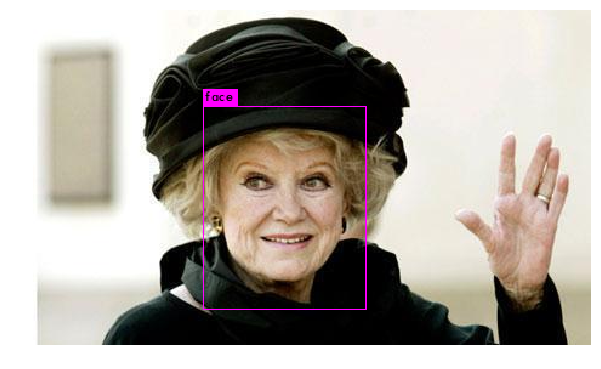

In [18]:
img_path = darknet_dir + "/predictions.png"

plt.figure(figsize=(10,10))

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

可以看出图片的框非常完美！